<!-- dom:TITLE: Demo - The Tau method -->
# Demo - The Tau method
<!-- dom:AUTHOR: Mikael Mortensen Email:mikaem@math.uio.no at Department of Mathematics, University of Oslo. -->
<!-- Author: -->  
**Mikael Mortensen** (email: `mikaem@math.uio.no`), Department of Mathematics, University of Oslo.

Date: **Jun 15, 2021**

Copyright 2021, Mikael Mortensen. Released under CC Attribution 4.0 license

**Summary.** Shenfun has primarily been developed for the spectral Galerkin method.
However, there are other methods out there that make use of global basis
functions and variational principles. One such method, which has a lot in
common with the spectral Galerkin method, is the Tau method. The
principle difference between a Tau method and a spectral Galerkin method
is in the choice of basis functions. The spectral Galerkin method is
usually defined through function spaces where the boundary conditions
of the problem are already built in. The tau-method, on the other hand,
does not come with such restrictions. The tau-method usually considers
only the orthogonal basis, like pure Chebyshev or Legendre polynomials,
and derives differentiation matrices for these bases. The boundary conditions
are usually fixed by enforcing a couple of rows of the differentiation
matrix. In this demo we will show how the original tau-method can
be easily implemented using [shenfun](https://github.com/spectralDNS/shenfun).













## The tau method for Poisson's equation in 1D

Poisson's equation is given on a domain $[-1, 1]$ as

<!-- Equation labels as ordinary links -->
<div id="eq:poisson"></div>

$$
\begin{equation}
\nabla^2 u(x) = f(x) \quad \text{for }\, x \in [-1, 1], \label{eq:poisson} \tag{1}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}  
u(-1)=a, u(1)=b, \notag
\label{_auto1} \tag{2}
\end{equation}
$$

where $u(x)$ is the solution, $f(x)$ is a function and $a, b$ are two possibly
non-zero constants.

To solve Eq. ([1](#eq:poisson)) with the tau method we choose either
Legendre of Chebyshev basis functions $\phi_k$, and then look for
solutions

<!-- Equation labels as ordinary links -->
<div id="eq:u"></div>

$$
\begin{equation}
u(x) = \sum_{k=0}^{N-1} \hat{u}_k \phi_k(x), \label{eq:u} \tag{3}
\end{equation}
$$

where $N$ is the size of the discretized problem and
$\hat{\mathbf{u}} = \{\hat{u}_k\}_{k=0}^{N-1}$ are the unknown expansion
coefficients. For this function to satisfy the given boundary conditions, it is necessary
that

<!-- Equation labels as ordinary links -->
<div id="eq:dirichleta"></div>

$$
\begin{equation}
u(-1) = \sum_{k=0}^{N-1} \hat{u}_k \phi_k(-1) = \sum_{k=0}^{N-1}\hat{u}_{k}(-1)^k = a,
\label{eq:dirichleta} \tag{4} 
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="eq:dirichletb"></div>

$$
\begin{equation}  
u(+1) = \sum_{k=0}^{N-1} \hat{u}_k \phi_k(+1) = \sum_{k=0}^{N-1} \hat{u}_{k} = b,
\label{eq:dirichletb} \tag{5}
\end{equation}
$$

where we have use that $\phi_k(1) = 1$ and $\phi_k(-1)=(-1)^k$ for $k=0,1, \ldots, N-1$,
for either Chebyshev or Legendre polynomials $\phi_k$.

This gives two equations for the $N-1$ unknowns in  $\{\hat{u}_k\}_{k=0}^{N-1}$.
We will now use variational principles, like in the Galerkin method, in order to
derive equations that can be used to close the remaining $N-3$ unknowns.
To this end we multiply Poisson's equation by a
test function $v$, a weight $w$, and integrate  over the domain

<!-- Equation labels as ordinary links -->
<div id="eq:varform"></div>

$$
\begin{equation}
\int_{-1}^1 \nabla^2 u \, v \, w\, dx = \int_{-1}^1 f \, v\, w\, dx. \label{eq:varform} \tag{6}
\end{equation}
$$

The weight function depends on the choice of basis functions. For Chebyshev
it will be $1/\sqrt{1-x^2}$, whereas it is unity for Legendre.

Finally, we insert the trial function $u=\sum_{j=0}^{N-1}\hat{u}_j \phi_j$ and
the test function $v=\phi_k$, to get

<!-- Equation labels as ordinary links -->
<div id="eq:varform2"></div>

$$
\begin{equation}
\int_{-1}^1 \sum_{j=0}^{N-1} \nabla^2 \phi_j  \, \phi_k \, w\, dx \hat{u}_j = \int_{-1}^1 f \, \phi_k\, w\, dx. \label{eq:varform2} \tag{7}
\end{equation}
$$

This problem can be reformulated as a linear algebra problem,

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
a_{kj} \hat{u}_j = \tilde{f}_k, 
\label{_auto2} \tag{8}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}  
A \hat{\mathbf{{u}}} = \tilde{\mathbf{{f}}}.
\label{_auto3} \tag{9}
\end{equation}
$$

However, the matrix $A\in \mathbb{R}^{N \times N}$ is singular because it
contains two zero rows. These two rows is where we implement the two boundary
conditions. By setting the rows as $a_{N-2, j}=1$ and
$a_{N-1, j}= (-1)^j$ for $j=0, 1, \ldots, N-1$, and fixing
the right hand side $\tilde{f}_{N-2}=a$ and $\tilde{f}_{N-1}=b$, the
two boundary conditions will be satisfied.

## Implementation

### Preamble

We will solve Poisson's equation using the [shenfun](https://github.com/spectralDNS/shenfun) Python module. The first thing needed
is then to import some of this module's functionality
plus some other helper modules, like [Numpy](https://numpy.org) and [Sympy](https://sympy.org):

In [1]:
from shenfun import inner, div, grad, TestFunction, TrialFunction, Function, \
    project, Dx, Array, FunctionSpace, dx
import numpy as np
import scipy.sparse as scp
from sympy import symbols, cos, sin, exp, lambdify

We use `Sympy` for a manufactured solution and `Numpy` for testing.
The exact manufactured solution $u_e(x)$ and the right hand side
$f_e(x)$ are created using `Sympy` as follows

In [2]:
x = symbols("x")
ue = sin(4*np.pi*x)
fe = ue.diff(x, 2)

Note that we compute the right hand side function `fe` that corresponds to
the manufactured solution `ue`.

### Discretization

We create a basis with a given number of basis functions, and extract the computational
mesh from the basis itself

In [3]:
N = 32
T = FunctionSpace(N, 'Chebyshev')
#T = FunctionSpace(N, 'Legendre')

Note that we can either choose a Legendre or a Chebyshev basis.

### Variational formulation

The variational problem ([6](#eq:varform)) can be assembled using `shenfun`'s
[TrialFunction](https://shenfun.readthedocs.io/en/latest/shenfun.forms.html#shenfun.forms.arguments.TrialFunction), [TestFunction](https://shenfun.readthedocs.io/en/latest/shenfun.forms.html#shenfun.forms.arguments.TestFunction) and [inner()](https://shenfun.readthedocs.io/en/latest/shenfun.forms.html#shenfun.forms.inner.inner) functions.

In [4]:
u = TrialFunction(T)
v = TestFunction(T)
# Assemble differentiation matrix
A = inner(v, div(grad(u)))
# Assemble right hand side
fj = Array(T, buffer=fe)
f_hat = Function(T)
f_hat = inner(v, fj, output_array=f_hat)

Note that the `sympy` function `fe` can be used to initialize the [Array](https://shenfun.readthedocs.io/en/latest/shenfun.forms.html#shenfun.forms.arguments.Array)
`fj`. We wrap this Numpy array in an [Array](https://shenfun.readthedocs.io/en/latest/shenfun.forms.html#shenfun.forms.arguments.Array) class
(`fj = Array(SD, buffer=fe)`), because an Array
is required as input to the [inner()](https://shenfun.readthedocs.io/en/latest/shenfun.forms.html#shenfun.forms.inner.inner) function. An
[Array](https://shenfun.readthedocs.io/en/latest/shenfun.forms.html#shenfun.forms.arguments.Array) contains the solution evaluated on the
quadrature mesh. A [Function](https://shenfun.readthedocs.io/en/latest/shenfun.forms.html#shenfun.forms.arguments.Function) represents a global
expansion, like Eq. ([3](#eq:u)), and its values are the
expansion coefficients $\{\hat{u}_{k}\}_{k=0}^{N-1}$.

### Fix boundary conditions

We fix two rows of the differentiation matrix in order to satisfy
Eqs. ([4](#eq:dirichleta)) and ([5](#eq:dirichletb)).

In [5]:
A = A.diags('lil')
A[-2] = (-1)**np.arange(N)
A[-1] = np.ones(N)
A = A.tocsc()
f_hat[-2] = ue.subs(x, T.domain[0])
f_hat[-1] = ue.subs(x, T.domain[1])

Note that the last two lines uses evaluation of the sympy function
`ue` at the borders of the domain. Implemented like this it is
easy to change to a nonstandard domain size.

### Solve linear equations

Finally, solve linear equation system and transform solution from spectral
$\{\hat{u}_k\}_{k=0}^{N-1}$ vector to the real space $\{u(x_j)\}_{j=0}^{N-1}$
and then check how the solution corresponds with the exact solution $u_e$.
To this end we compute the $L_2$-errornorm using the `shenfun` function
[dx()](https://shenfun.readthedocs.io/en/latest/shenfun.utilities.html#shenfun.utilities.dx)

In [6]:
u_hat = Function(T)
u_hat[:] = scp.linalg.spsolve(A, f_hat)
uj = u_hat.backward()
ua = Array(T, buffer=ue)

print("Error=%2.16e" %(np.sqrt(dx((uj-ua)**2))))

Error=6.1627548407139349e-11


### Convergence test

To do a convergence test we will now create a function `main`, that takes the
number of quadrature points as parameter, and prints out
the error.

In [7]:
def main(N, family='Chebyshev'):
    T = FunctionSpace(N, family=family)
    u = TrialFunction(T)
    v = TestFunction(T)

    # Get f on quad points
    fj = Array(T, buffer=fe)

    # Compute right hand side of Poisson's equation
    f_hat = Function(T)
    f_hat = inner(v, fj, output_array=f_hat)

    # Get left hand side of Poisson's equation
    A = inner(v, div(grad(u)))
    A = A.diags('lil')
    A[-2] = (-1)**np.arange(N)
    A[-1] = np.ones(N)
    A = A.tocsc()
    f_hat[-2] = ue.subs(x, T.domain[0])
    f_hat[-1] = ue.subs(x, T.domain[1])

    u_hat = Function(T)
    u_hat[:] = scp.linalg.spsolve(A, f_hat)
    uj = u_hat.backward()

    # Compare with analytical solution
    ua = Array(T, buffer=ue)
    l2_error = np.linalg.norm(uj-ua)
    return l2_error

For example, we find the error of a Chebyshev discretization
using 12 quadrature points as

In [8]:
main(12, 'Chebyshev')

1.9741838920185595

To get the convergence we call `main` for a list
of $N=[12, 16, \ldots, 48]$, and collect the errornorms in
arrays to be plotted. The error can be plotted using
[matplotlib](https://matplotlib.org).

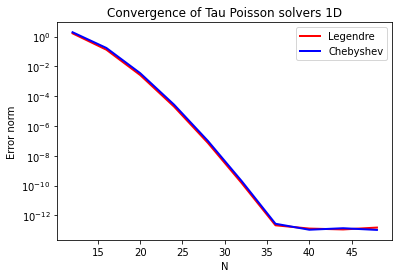

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

N = range(12, 50, 4)
error = {}
for basis in ('legendre', 'chebyshev'):
    error[basis] = []
    for i in range(len(N)):
        errN = main(N[i], basis)
        error[basis].append(errN)

plt.figure(figsize=(6, 4))
for basis, col in zip(('legendre', 'chebyshev'), ('r', 'b')):
    plt.semilogy(N, error[basis], col, linewidth=2)
plt.title('Convergence of Tau Poisson solvers 1D')
plt.xlabel('N')
plt.ylabel('Error norm')
plt.legend(('Legendre', 'Chebyshev'))
plt.show()

The spectral convergence is evident and we can see that
after $N=40$ roundoff errors dominate as the errornorm trails off around $10^{-14}$.

## Complete solver
<div id="sec:complete"></div>

A complete solver, that can use either Legendre or Chebyshev bases, chosen as a
command-line argument, can also be found [here](https://github.com/spectralDNS/shenfun/blob/master/demo/poisson1D_tau.py).

<!-- ======= Bibliography ======= -->